In [2]:
import mlflow

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


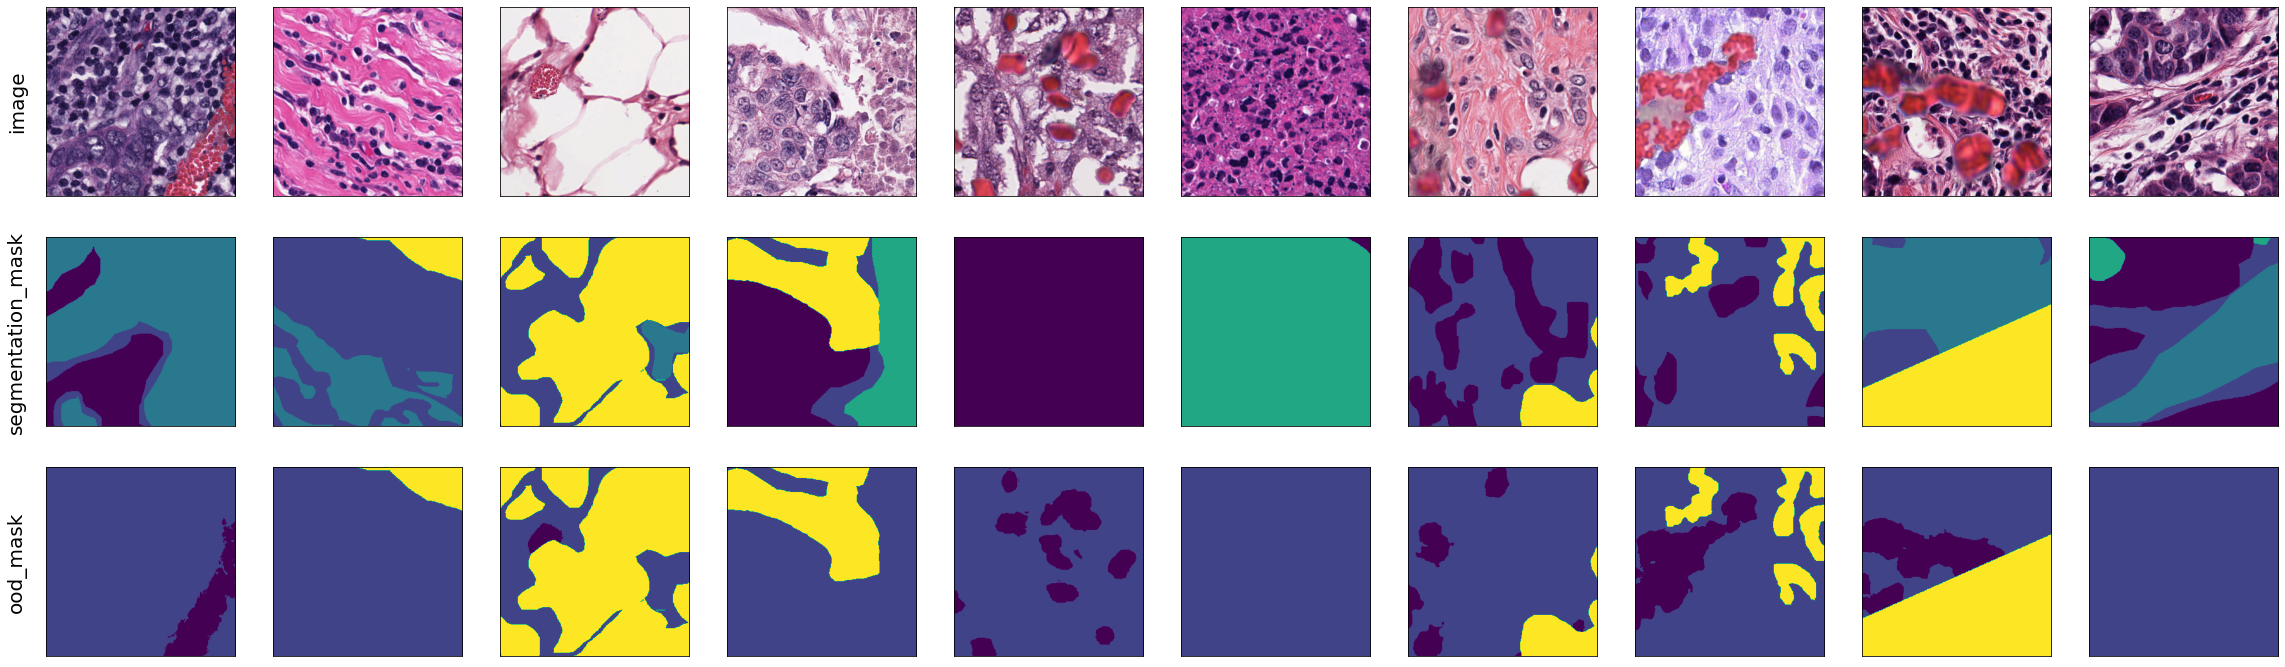

OOD Evaluation:   0%|          | 0/134 [00:00<?, ?it/s]c:\Users\jstieber\AppData\Local\conda\conda\envs\ssl4uc\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
OOD Evaluation: 100%|██████████| 134/134 [01:25<00:00,  1.56it/s]


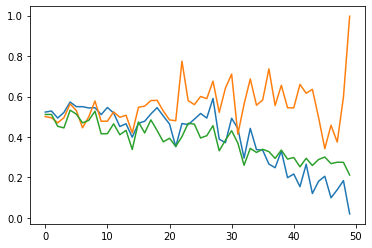

Name                               AUC
----------------------------  --------
OOD_SCORE.0_MaxClassBaseline  0.484326
OOD_SCORE.1_ODIN              0.521144
OOD_SCORE.2_EnergyBased       0.449869


'\n\ncomponent = DatasetOODEvaluationComponent(\n    [BCSS_Adapted_Cropped_Resized_Datasets().val],\n    [BCSS_Adapted_Cropped_Resized_Datasets().test],\n    net,\n    seed=4321\n)\n\ncomponent()\n'

In [1]:
from digipat.models.segmentation import SegmentationModel
from digipat.data.datasets.examples.bcss import (
    BCSS_OOD_Dataset,
    BCSS_Base_Dataset,
    BCSS_Adapted_Datasets,
    BCSS_Adapted_Cropped_Resized_Datasets,
)
from digipat.data.datasets.interfaces import OODDataset
from digipat.ood.augmentations import *
from digipat.data.metadata import SampleMetadataCommonTypes
from digipat.data.container import MetadataContainer
from digipat.ood.metrics import OODAuRoC, infer_container
from digipat.ood.strategies import AugmentationStrategy, OODDatasetsStrategy
from digipat.ood.methods import ODIN, EnergyBased, MaxClassBaseline
from digipat.ood.augmentations.utility.pipeline import SizeInOODPipeline
from digipat.ood.augmentations.indistribution import InResize, InCrop
from digipat.ood.augmentations.pathology.deforming import OverlapAugmentation
from digipat.experiment.components.examples import (
    AugmentationOODEvaluationComponent,
    DatasetOODEvaluationComponent,
)
from digipat.data.datasets.adapter import AlreadyASampleAdapter
from digipat.ood.augmentations.pathology.artifacts.blood_group import BloodGroupAugmentation

import matplotlib.pyplot as plt
import tqdm
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, ConcatDataset


net = SegmentationModel().load()
metrics = [OODAuRoC(group_by="bin", num_bins=50), OODAuRoC()]



component = AugmentationOODEvaluationComponent(
    BCSS_Adapted_Cropped_Resized_Datasets().test,
    SizeInOODPipeline(
        ood_augmentations=[NTimesAugmentation(SampledOODAugmentation(BloodGroupAugmentation()), 10)],
    ),
    net,
    metrics=metrics,
    seed=4321,
)


component()
"""

component = DatasetOODEvaluationComponent(
    [BCSS_Adapted_Cropped_Resized_Datasets().val],
    [BCSS_Adapted_Cropped_Resized_Datasets().test],
    net,
    seed=4321
)

component()
"""

In [ ]:
OOD_SCORE.0_MaxClassBaseline  0.503561
OOD_SCORE.1_ODIN              0.529182
OOD_SCORE.2_EnergyBased       0.571044

OOD_SCORE.0_MaxClassBaseline  0.502997
OOD_SCORE.1_ODIN              0.533582
OOD_SCORE.2_EnergyBased       0.569928

OOD_SCORE.0_MaxClassBaseline  0.502416
OOD_SCORE.1_ODIN              0.532223
OOD_SCORE.2_EnergyBased       0.567983

OOD_SCORE.0_MaxClassBaseline  0.503873
OOD_SCORE.1_ODIN              0.531278
OOD_SCORE.2_EnergyBased       0.57202

OOD_SCORE.0_MaxClassBaseline  0.501726
OOD_SCORE.1_ODIN              0.53195
OOD_SCORE.2_EnergyBased       0.5698

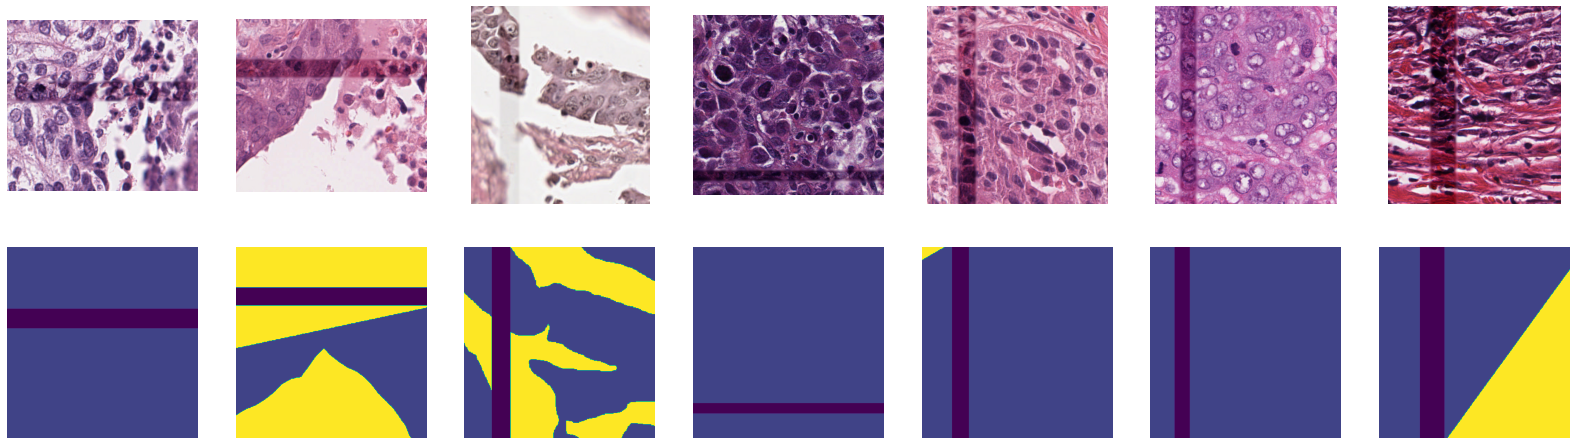

In [390]:
aug = OverlapAugmentation()
BCSS_OOD_Dataset(bcss_base=BCSS_Base_Dataset(resize_size=(350,350), crop_size=(700,700),size=(700,700)),augmentation=aug).sample(7)



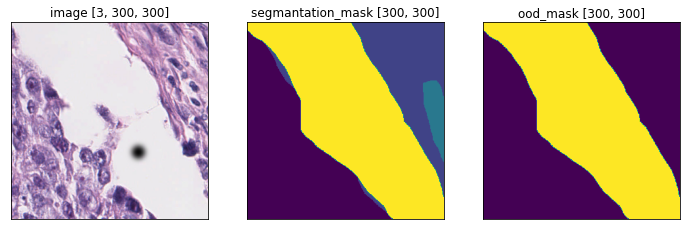

DistributionSampleType.IN_DATA - dict_items([('type', <DistributionSampleType.IN_DATA: 2>), ('ignore_index', 5)])


In [12]:
from digipat.data.samples import Sample, Batch
from digipat.data.datasets.examples.bcss import BCSS_OOD_Dataset, BCSS_Base_Dataset, BCSS_Adapted_Dataset
from digipat.data.datasets.adapter.adapter import (
    PositionalAdapter,
    ImageLabelMetaAdapter,
)
from digipat.data.datasets.adapter.utils import create_mapping_dict
from digipat.data.datatypes import DistributionSampleType
from digipat.data.metadata import SampleMetadata
import matplotlib.pyplot as plt
from digipat.ood.augmentations.pathology.artifacts import *
from digipat.ood.augmentations.utility.pipeline import SizeInOODPipeline
from digipat.ood.augmentations.indistribution import InResize, InCrop
from digipat.ood.augmentations.pathology.deforming import OverlapAugmentation


adapter = ImageLabelMetaAdapter(BCSS_Base_Dataset(size=(620,620)), ignore_index=5)
# adapter.sample(7)

a = SizeInOODPipeline(size_augmentations=[] , in_augmentations=[InCrop((600,600)), InResize(resize_size=(300,300))], ood_augmentations=[DarkSpotsAugmentation(0.2, keep_ignorred=True)])

a(adapter[1000]).plot()


In [5]:
overlay = 50
shuffle = 3
sigma = 1.5
import random

flip = random.uniform(0,1) > 0.5

start = int(
    random.uniform(
        overlay, npimg.shape[0] - 2*overlay if not flip else npimg.shape[1] - 2*overlay
    )
)
start = npimg.shape[0] - 2*overlay
print(start, overlay)

from skimage.filters import gaussian


def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
    return result


part1 = np.ones((npimg.shape[0] - overlay, npimg.shape[1], 3))
part2 = np.ones((npimg.shape[0] - overlay, npimg.shape[1], 3))
print(part1.shape)

if flip:
    npimg = npimg.transpose(1, 0, 2)

part1[start:, ...] = npimg[start + overlay :, ...]
part2[: start + overlay, ...] = npimg[: start + overlay, ...]

result = part1 * part2
shuffle1 = result[start - shuffle : start + shuffle, ...]
shuffle1 = gaussian(shuffle1, sigma=sigma, multichannel=True)
result[start - shuffle : start + shuffle, ...] = shuffle1

shuffle2 = result[start + overlay - shuffle : start + overlay + shuffle, ...]
shuffle2 = gaussian(shuffle2, sigma=sigma, multichannel=True)
result[start + overlay - shuffle : start + overlay + shuffle, ...] = shuffle2

if flip:
    result = result.transpose(1, 0, 2)
    part1 = part1.transpose(1, 0, 2)
    part2 = part2.transpose(1, 0, 2)
    npimg = npimg.transpose(1, 0, 2)


plot_imgs(part1, part2, result)


NameError: name 'npimg' is not defined

In [3]:
container[0].metaframe

,type,OOD_SCORE.0_MaxClassBaseline,OOD_SCORE.1_ODIN,OOD_SCORE.2_EnergyBased,OOD_REASON,OOD_SEVERITY
0,DistributionSampleType.IN_DATA,0.945204,0.856117,4.047712,NaN,NaN
1,DistributionSampleType.OOD_DATA,0.922269,0.850095,3.606822,OODReason.AUGMENTATION_OOD,PixelPercentage [0-1]: 0.0727333351969719
2,DistributionSampleType.OOD_DATA,0.955794,0.767361,3.641944,OODReason.AUGMENTATION_OOD,PixelPercentage [0-1]: 0.8094221949577332
3,DistributionSampleType.IN_DATA,0.988795,0.850593,4.387804,NaN,NaN
4,DistributionSampleType.IN_DATA,0.943523,0.948003,5.573709,NaN,NaN
...,...,...,...,...,...,...
15232,DistributionSampleType.IN_DATA,0.890632,0.846623,3.545717,NaN,NaN
15233,DistributionSampleType.IN_DATA,0.969188,0.869987,3.692738,NaN,NaN
15234,DistributionSampleType.OOD_DATA,0.927643,0.768093,3.546924,OODReason.AUGMENTATION_OOD,PixelPercentage [0-1]: 0.9846888780593872
15235,DistributionSampleType.OOD_DATA,0.962215,0.832451,3.665650,OODReason.AUGMENTATION_OOD,PixelPercentage [0-1]: 0.3379777669906616


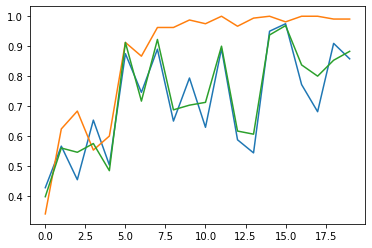

Name                               AUC
----------------------------  --------
OOD_SCORE.0_MaxClassBaseline  0.691719
OOD_SCORE.1_ODIN              0.822188
OOD_SCORE.2_EnergyBased       0.699688


In [20]:
for m in metrics:
    m(container, {})
    m.present()

In [3]:
t = container[0].metaframe

In [14]:
in_d = t[(t["type"] == DistributionSampleType.IN_DATA)]
t["bin"] = t["OOD_SEVERITY"].apply(lambda x: x.get_bin(10) if not pd.isna(x) else None)
od_d = t[(t["type"] == DistributionSampleType.OOD_DATA)].groupby("bin")
d_col = [col for col in t if col.startswith(f"{MetadataCommonTypes.OOD_SCORE.name}.")]

print(in_d[d_col].to_numpy())
ood_nested_list = od_d[d_col].apply(lambda x: x.values.tolist()).tolist()
print(ood_nested_list[0][0].__len__())
group_keys = od_d[d_col].groups.keys()

for i, g_k in enumerate(group_keys):
        group_array = np.array(ood_nested_list[i])
        print(group_array.shape)


[[0.92389035 0.87533647 3.5593965 ]
 [0.94760615 0.8359803  3.685302  ]
 [0.94832206 0.85631496 3.733188  ]
 [0.94323003 0.84102124 3.6675391 ]
 [0.95110714 0.8496221  3.7241695 ]
 [0.9618157  0.8231528  3.854208  ]
 [0.98498964 0.8371119  3.9649193 ]
 [0.9872153  0.9756489  4.5679603 ]
 [0.9888574  0.97117984 4.6788077 ]
 [0.96790093 0.88533854 3.7843442 ]
 [0.96479464 0.8476159  3.7739418 ]
 [0.96498907 0.82996565 3.8229992 ]
 [0.94273126 0.8468528  3.6979208 ]
 [0.97448194 0.8434435  3.8879    ]
 [0.9929835  0.9838268  4.7519445 ]
 [0.99280167 0.9758616  4.7293367 ]
 [0.9309308  0.79028106 3.8988843 ]
 [0.9362447  0.8328053  3.6691053 ]
 [0.9608033  0.86808306 3.795631  ]
 [0.9620141  0.93651164 4.0511985 ]
 [0.9830834  0.96452945 4.389062  ]
 [0.9414311  0.8434523  3.6555576 ]
 [0.9472843  0.8100232  3.8589597 ]
 [0.9464342  0.8499617  3.7256305 ]
 [0.96348834 0.8666326  3.7924397 ]
 [0.9470222  0.8857116  3.701381  ]
 [0.95910937 0.9325229  3.966458  ]
 [0.94806087 0.87347853 3.66

In [46]:
import pandas as pd

print(all[0].data)
test = pd.json_normalize([a.data for a in all])
DistributionSampleType.IN_DISTRIBUTION_DATA.name
test

defaultdict(<function dict_default at 0x000001ED31BCC310>, {'type': <DistributionSampleType.AUGMENTATION_OOD_DATA: 3>, 'OOD_SEVERITY': PixelPercentage [0-1]: 0.8070555329322815, 'OOD_SCORE': {'0_MaxClassBaseline': 0.95399994, '1_ODIN': 0.7659604, '2_EnergyBased': 3.6314614}})


,type,OOD_SEVERITY,OOD_SCORE.0_MaxClassBaseline,OOD_SCORE.1_ODIN,OOD_SCORE.2_EnergyBased
0,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.8070555329322815,0.954000,0.765960,3.631461
1,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.955697,0.919083,3.948238
2,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.949582,0.841722,3.643372
3,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.05165555700659752,0.961023,0.837734,3.891705
4,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.04721111059188843,0.950182,0.828156,3.796163
...,...,...,...,...,...
1595,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.08364444226026535,0.946027,0.865525,4.217421
1596,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.957214,0.907939,5.377982
1597,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.4543111026287079,0.951531,0.851290,5.022236
1598,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.6734222173690796,0.920955,0.753346,4.079607


In [51]:
test[test["type"] == DistributionSampleType.IN_DISTRIBUTION_DATA]
test["bin"] = test["OOD_SEVERITY"].apply(lambda x: x.get_bin(10) if not pd.isna(x) else None)
in_d = test[(test["type"] == DistributionSampleType.IN_DISTRIBUTION_DATA)]
in_d

,type,OOD_SEVERITY,OOD_SCORE.0_MaxClassBaseline,OOD_SCORE.1_ODIN,OOD_SCORE.2_EnergyBased,bin
1,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.955697,0.919083,3.948238,NaN
2,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.949582,0.841722,3.643372,NaN
6,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.975786,0.853905,3.842583,NaN
7,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.980347,0.853312,3.942138,NaN
14,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.952342,0.839062,3.724517,NaN
...,...,...,...,...,...,...
1587,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.921613,0.829729,3.551795,NaN
1588,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.978674,0.875985,4.185493,NaN
1590,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.980023,0.878146,4.149152,NaN
1591,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.974337,0.878608,4.232892,NaN


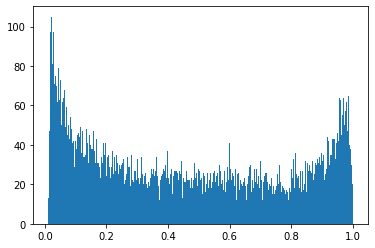

In [6]:
    # print(np.mean(score,tuple(range(1, score.ndim))))
    # all.extend(
    #    [
    #        m["severity"].measurement
    #        for m in meta
    #        if m.type is DistributionSampleType.AUGMENTATION_OOD_DATA
    #    ]
    # )

import numpy as np
plt.hist(all, 500)
plt.show()


In [52]:
data= {"test": 5, "lol": 3}
for key, val in data.items():
            print(key, val)

test 5
lol 3


In [ ]:

"""
shuffle1 = part1[start-1:start + 1,...]
shuffle2 = part2[start + overlay -1:start + overlay +1,...]
s = shuffle1.shape
shuffle1 = shuffle1.reshape(-1,3)
shuffle2 = shuffle2.reshape(-1,3)
np.random.shuffle(shuffle1)
np.random.shuffle(shuffle2)
plt.imshow(shuffle1.reshape(s))




l = 1
for i in range(0, shuffle1.shape[1],l):
  patch = shuffle1[:,i:i+l,:]
  s = patch.shape
  patch = patch.reshape(-1,3)
  np.random.shuffle(patch)
  new_patch = patch.reshape(s)
  shuffle1[:,i:i+l,:] = new_patch



for i in range(0, shuffle2.shape[1],l):
  patch = shuffle2[:,i:i+l,:]
  s = patch.shape
  patch = patch.reshape(-1,3)
  np.random.shuffle(patch)
  new_patch = patch.reshape(s)
  shuffle2[:,i:i+l,:] = new_patch

"""

#
#print(shuffle2.reshape(-1,3).shape)
#np.random.shuffle(shuffle2.reshape(-1,3))